In [1]:
import matplotlib.pyplot as plt
import os
import pandas as pd
import numpy as np
import quantumpropagator as qp
from quantumpropagator import readWholeH5toDict, abs2
#from __future__ import print_function
from ipywidgets import interact#, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.axes_grid1 import make_axes_locatable

In [2]:
subfolders = sorted([ dir for dir in os.listdir('.') if os.path.isdir(dir) and dir != '.ipynb_checkpoints'])
print(''.join(['{} -> {}\n'.format(a,b) for a,b in enumerate(subfolders)]))

0 -> aaa_input_FinerGrid_0027
1 -> aaa_input_FinerGrid_0031
2 -> bbb_finerfinergrid_exploding
3 -> bbb_finergrid_3d_withoutpotential
4 -> distort_input_FinerGrid_0000
5 -> distort_input_FinerGrid_0001
6 -> distort_input_FinerGrid_0002
7 -> distort_input_FinerGrid_0003
8 -> distort_input_FinerGrid_0004
9 -> distort_input_FinerGrid_0005
10 -> distort_input_FinerGrid_0006
11 -> distort_input_FinerGrid_0007
12 -> distort_input_FinerGrid_0008
13 -> distort_input_FinerGrid_0009
14 -> distort_input_FinerGrid_0010
15 -> distort_input_FinerGrid_0011
16 -> distort_input_FinerGrid_0012
17 -> distort_input_FinerGrid_0013
18 -> distort_input_FinerGrid_0014
19 -> distort_input_FinerGrid_0015
20 -> distort_input_FinerGrid_0016
21 -> distort_input_FinerGrid_0017



In [3]:
a = subfolders[-1]
a = subfolders[2]

In [4]:
filesList = [ fn for fn in sorted(os.listdir(a)) if fn[:8] == 'Gaussian' and fn[-3:] == '.h5']
outh5 = os.path.join(a,'allInput.h5')
dictio = readWholeH5toDict(outh5)
phis,gams,thes = dictio['phis'],dictio['gams'],dictio['thes']
lastV = len(filesList)-1
# dictio.keys()
zeroWF = qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')
vmaxV = abs2(zeroWF).max()
phiL,gamL,theL,nstates = (qp.retrieve_hdf5_data(os.path.join(a,filesList[0]),'WF')).shape

####################### HERE PHI IS MAGNIFICATED, NOT GOOD #########################################

phisT = phis*100
gamsT = np.rad2deg(gams)
thesT = np.rad2deg(thes)*2

equi_p = 56
equi_g = 40
equi_t = 56

In [5]:
def heatThisP(h5File,first,second,vmaxV,state,sliced,which,save=None):
    '''
    
    '''
    aaa = np.rad2deg
    save = save or False
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    #fig = plt.figure(figsize=(10, 10), dpi= 80, facecolor='w', edgecolor='k')
    plt.title('Time = {:10.5f} fs'.format(time))

    if which == 'phi':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[sliced,:,:,state]
        plt.ylabel('Gamma')
        plt.xlabel('Theta')
        ext = [aaa(second[0]),aaa(second[-1]),aaa(first[0]),aaa(first[-1])]
    
    elif which == 'gam':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[:,sliced,:,state]
        plt.ylabel('Phi')
        plt.xlabel('Theta')
        ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
        
    elif which == 'the':
        wf   = qp.retrieve_hdf5_data(h5File,'WF')[:,:,sliced,state]
        plt.ylabel('Phi')
        plt.xlabel('Gamma')
        ext = [aaa(second[0]),aaa(second[-1]),first[0]*50,first[-1]*50]
    

    
    # this is to get a nice colorbar on the side
    ax = plt.gca()

    im = ax.imshow(qp.abs2(wf), extent=ext, cmap='hot', vmax=vmaxV)
    #im = ax.imshow(qp.abs2(wf), cmap='PuBu_r', vmax=0.4)
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)

    plt.colorbar(im, cax=cax)
    
    if save:
        fig.savefig(os.path.splitext(h5File)[0] + '.png')
        plt.close()

# Phi Slices

In [6]:
def f_tg(frame,state,phi):
    return heatThisP(os.path.join(a,filesList[frame]),gams,thes,vmaxV,state,phi,'phi')

interact(f_tg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p));
createimages = False

interactive(children=(IntSlider(value=19, description='frame', max=19), IntSlider(value=0, description='state'…

# Gamma slices

In [7]:
def f_pt(frame, state, gamma):
    return heatThisP(os.path.join(a,filesList[frame]),phis,thes,vmaxV,state,gamma,'gam')

interact(f_pt, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g));

interactive(children=(IntSlider(value=19, description='frame', max=19), IntSlider(value=0, description='state'…

# Theta slices

In [8]:
def f_pg(frame, state, theta):
    return heatThisP(os.path.join(a,filesList[frame]),phis,gams,vmaxV,state,theta,'the')

interact(f_pg, frame = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV),state = widgets.IntSlider(min=0,max=nstates-1,step=1,value=0), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t));

interactive(children=(IntSlider(value=19, description='frame', max=19), IntSlider(value=0, description='state'…

# 1d slices

In [9]:
def slice1D(h5File, first, second, label, exa):
    wf  = qp.retrieve_hdf5_data(h5File,'WF')
    fig = plt.figure(figsize=(11, 6), dpi= 80, facecolor='w', edgecolor='k')
    time = qp.retrieve_hdf5_data(h5File,'Time')[0]
    plt.ylim(-0.5,0.5)
    if label == 'phi':
        ys = wf[:,first,second,:]*exa
        plt.title('Time = {:10.5f} fs | gamma = {:8.3f} | theta = {:8.3f}'.format(time,gamsT[first],thesT[second]))
        labelsX = phisT
        plt.xlabel('Phi')
    if label == 'gam':
        ys = wf[first,:,second,:]*exa
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | theta = {:8.3f}'.format(time,phisT[first],thesT[second]))
        labelsX = gamsT
        plt.xlabel('Gamma')
    if label == 'the':
        ys = wf[first,second,:,:]*exa
        plt.title('Time = {:10.5f} fs | phi = {:8.3f} | gamma = {:8.3f}'.format(time,phisT[first],gamsT[second]))
        labelsX = thesT
        plt.xlabel('Theta')
    
    plt.plot(labelsX, np.real(ys), linewidth=1,ls='--')
    plt.plot(labelsX, np.imag(ys), linewidth=1,ls='--')
    plt.plot(labelsX, abs2(ys), linewidth=3,ls='-')

## 1D Phi

In [10]:
def fphi(file_number,gamma, theta,exa):
    return slice1D(os.path.join(a, filesList[file_number]), gamma, theta, 'phi', exa)

interact(fphi, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=19, description='file_number', max=19), IntSlider(value=40, description=…

## 1D Gamma

In [11]:
def fgam(file_number,phi,theta,exa):
    return slice1D(os.path.join(a, filesList[file_number]), phi, theta, 'gam', exa)

interact(fgam, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), theta = widgets.IntSlider(min=0,max=theL-1,step=1,value=equi_t), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=19, description='file_number', max=19), IntSlider(value=56, description=…

## 1D Theta

In [12]:
def fthe(file_number,phi,gamma,exa):
    return slice1D(os.path.join(a, filesList[file_number]), phi, gamma, 'the', exa)

interact(fthe, file_number = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV), phi = widgets.IntSlider(min=0,max=phiL-1,step=1,value=equi_p), gamma = widgets.IntSlider(min=0,max=gamL-1,step=1,value=equi_g), exa = widgets.IntSlider(min=1,max=10,step=1,value=1));

interactive(children=(IntSlider(value=19, description='file_number', max=19), IntSlider(value=56, description=…

# Population and Energies

In [13]:
outfn = os.path.join(a,'output')
outfnP = os.path.join(a,'outputPopul')
data = pd.read_csv(outfn, delim_whitespace=True, header=None);
dataP = pd.read_csv(outfnP, delim_whitespace=True, header=None);
data.columns = ['steps','fs','Norm Deviation','Kinetic','Potential','Total','Total deviation','Xpulse','Ypulse','Zpulse']

In [14]:
result = pd.concat([data, dataP], axis=1)
result

,steps,fs,Norm Deviation,Kinetic,Potential,Total,Total deviation,Xpulse,Ypulse,Zpulse,0,1,2
0,0.0,0.000000,2.886580e-15,1.014629e+00,7.576573e-01,1.772286e+00,0.000000e+00,0.0,0.0,0.0,0.0000,1.000000e+00,0.0
1,20.0,0.200199,1.334800e-06,9.756638e-01,7.966048e-01,1.772269e+00,1.740717e-05,0.0,0.0,0.0,0.2002,9.999970e-01,0.0
2,40.0,0.400397,5.582199e-06,8.746146e-01,8.976290e-01,1.772244e+00,4.244102e-05,0.0,0.0,0.0,0.4004,9.999890e-01,0.0
3,60.0,0.600596,1.398517e-05,7.528658e-01,1.019334e+00,1.772200e+00,8.632255e-05,0.0,0.0,0.0,0.6006,9.999720e-01,0.0
4,80.0,0.800794,2.852449e-05,6.616741e-01,1.110456e+00,1.772130e+00,1.559005e-04,0.0,0.0,0.0,0.8008,9.999430e-01,0.0
5,100.0,1.000993,-4.827960e+02,3.747167e+07,1.245613e+07,4.992780e+07,-4.992780e+07,0.0,0.0,0.0,1.0010,2.340590e+05,0.0
6,120.0,1.201191,-3.297139e+10,1.740295e+23,5.812155e+22,2.321511e+23,-2.321511e+23,0.0,0.0,0.0,1.2012,1.087110e+21,0.0
7,140.0,1.401390,-2.990376e+18,1.430425e+39,4.935325e+38,1.923957e+39,-1.923957e+39,0.0,0.0,0.0,1.4014,8.942350e+36,0.0
8,160.0,1.601588,-7.948703e+27,1.006086e+58,4.048234e+57,1.410910e+58,-1.410910e+58,0.0,0.0,0.0,1.6016,6.318190e+55,0.0
9,180.0,1.801787,-1.532773e+38,3.740075e+78,1.535719e+78,5.275794e+78,-5.275794e+78,0.0,0.0,0.0,1.8018,2.349390e+76,0.0


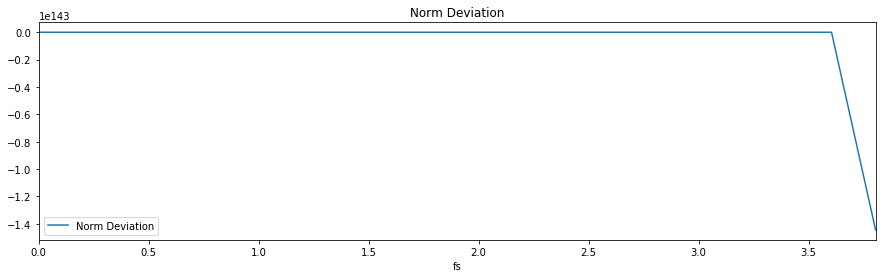

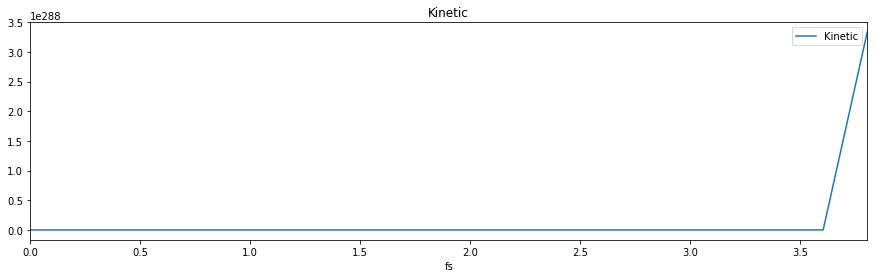

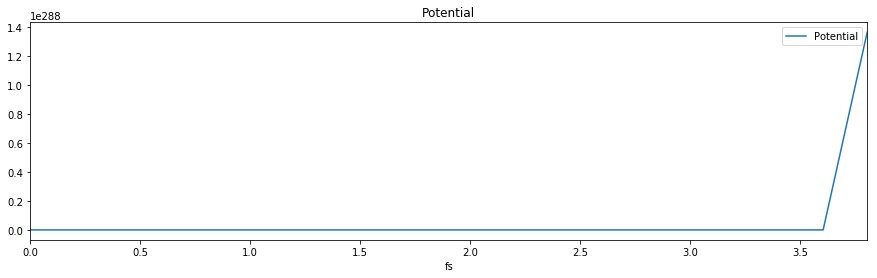

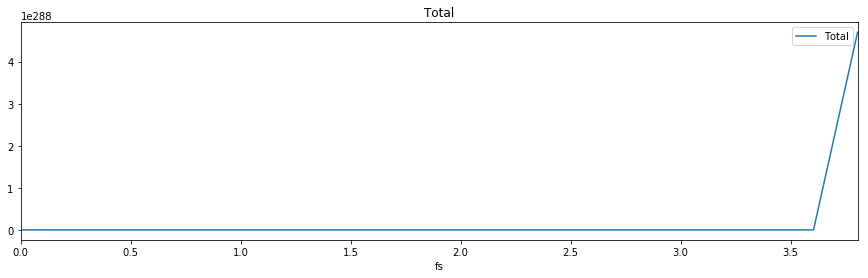

In [15]:
data.plot(title = 'Norm Deviation', x='fs', y = 'Norm Deviation', figsize=(15,4));
data.plot(title = 'Kinetic', x='fs', y = 'Kinetic', figsize=(15,4));
data.plot(title = 'Potential', x='fs', y = 'Potential', figsize=(15,4));
data.plot(title = 'Total', x='fs', y = 'Total', figsize=(15,4));

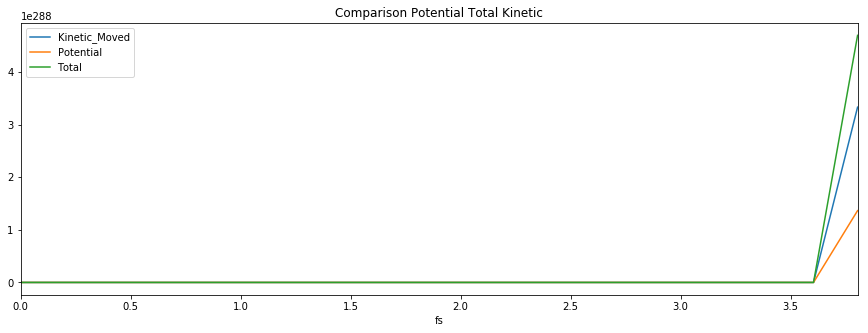

In [16]:
data['Kinetic_Moved'] = data['Kinetic'] + data['Potential'][0]
data.plot(title = 'Comparison Potential Total Kinetic', x=['fs'] ,y=['Kinetic_Moved','Potential','Total'], figsize=(15,5));

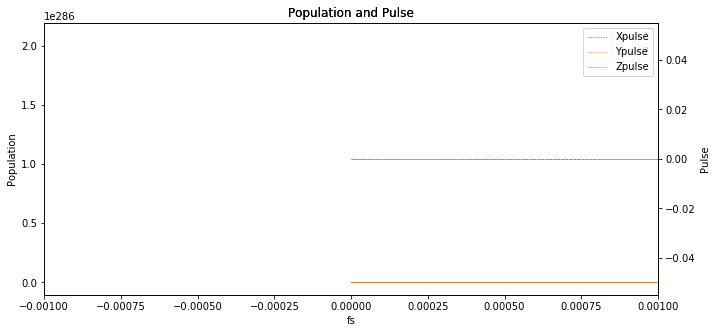

In [17]:
fig = plt.figure(figsize=(11,5))
ax1 = fig.add_subplot(111)
ax2 = ax1.twinx()
ax1.set_ylabel('Population')
ax2.set_ylabel('Pulse')
popul = np.arange(nstates)+1
result.plot(title = 'Population and Pulse', ax = ax1,  x=['fs'] ,y=popul, linewidth=0.8)
result.plot(title = 'Population and Pulse', ax = ax2,  x=['fs'] ,y=['Xpulse','Ypulse','Zpulse'], linewidth=0.5,ls='--');

## Expected values

In [18]:
def expected(h5file):
    wf  = qp.retrieve_hdf5_data(h5file,'WF')
    time = qp.retrieve_hdf5_data(h5file,'Time')[0]
    print('Time: {:5.2f} fs'.format(time))
    _,_,_,nstates = wf.shape
    for i in range(nstates):
        wfState = wf[:,:,:,i]
        popu = np.linalg.norm(wfState) # this is norm, the real popu is this squared
        if popu == 0:
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi: - \n  Theta: - \n  Gamma: -'.format(i, popu**2))
        else:
            wfA = abs2(wfState/popu)
            # We need to sun and then sum again. From 3d to 1d.
            phiAvg = np.sum(np.sum(wfA,axis=2),axis=1)
            gamAvg = np.sum(np.sum(wfA,axis=2),axis=0)
            theAvg = np.sum(np.sum(wfA,axis=1),axis=0)
            phiA = sum([ phisT[i] * phiAvg[i] for i in range(phiAvg.size) ])
            gamA = sum([ gamsT[i] * gamAvg[i] for i in range(gamAvg.size) ])
            theA = sum([ thesT[i] * theAvg[i] for i in range(theAvg.size) ])
            print('Expected Values State {}:\nPopul: {:10.3f} \n  Phi:   {:10.3f} \n  Theta: {:10.3f} \n  Gamma: {:10.3f}'.format(i, popu**2, phiA, theA, gamA))

def fexp(x):
    return expected(os.path.join(a,filesList[x]))

interact(fexp, x = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

interactive(children=(IntSlider(value=19, description='x', max=19), Output()), _dom_classes=('widget-interact'…

## Look at side of cell

In [19]:
def side(h5file):
    wf  = qp.retrieve_hdf5_data(h5file,'WF')
    time = qp.retrieve_hdf5_data(h5file,'Time')[0]
    print('Time: {:5.2f} fs'.format(time))
    wfAB = qp.abs2(wf)
    print('Phi -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[-1,:,:,0]),np.sum(wfAB[0,:,:,0])))
    print('Gam -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,-1,:,0]),np.sum(wfAB[:,0,:,0])))
    print('The -> {:5.2e} {:5.2e}'.format(np.sum(wfAB[:,:,-1,0]),np.sum(wfAB[:,:,0,0])))


def side_f(x):
    return side(os.path.join(a,filesList[x]))
    
interact(side_f, x = widgets.IntSlider(min=0,max=lastV,step=1,value=lastV));

interactive(children=(IntSlider(value=19, description='x', max=19), Output()), _dom_classes=('widget-interact'…